<a href="https://colab.research.google.com/github/pkumar2143/cancer-detect-revisit/blob/main/CVforBreastCancerDetection_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Project for Breast Cancer Detection
This project is a revisit to a grad project I undertook creating a CNN-based system for detecting breast cancer in RGB images; see the repo [here](https://github.com/pkumar2143/CNN-CompVis). I initially could not improve the performance of my model at the time more than about 86% due to time and resource constraints, but let's see if we can do so now.

### The Dataset

From the Kaggle Dataset, Breast Histopathology:

The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x.

From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive).

Each patch’s file name is of the format: u_xX_yY_classC.png — > example 10253_idx5_x1351_y1101_class0.png . Where u is the patient ID (10253_idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

In [1]:
import sys
import os
import kagglehub
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Download latest dataset version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-histopathology-images' dataset.
Path to dataset files: /kaggle/input/breast-histopathology-images


In [3]:
%cd {path}

/kaggle/input/breast-histopathology-images


In [4]:
# Exploring folders
print(len(os.listdir(path)))

280


There are actually 279 folders, which by the dataset description above, represent 279 patients. The 280th dir seems to be a copy of the dataset within the dataset, need to check further...

In [5]:
# Seems to be a copy of the dataset within the dataset, need to check further...
print(len(os.listdir(path + "/IDC_regular_ps50_idx5")))

279


In [6]:
print(os.listdir(path))

['10295', '10304', '12868', '10274', '12818', '14190', '12869', '9323', '10291', '12906', '9176', '8984', '10299', '12930', '9344', '12935', '12894', '12909', '9381', '9346', '9175', '10262', '8980', '16896', '12241', '12910', '13617', '13401', '12891', '10300', '9076', '10259', '9124', '13402', '12870', '16550', '10255', '9261', '15471', '12931', '12955', '10258', '13461', '13023', '9260', '8957', '9035', '10268', '13403', '10288', '9262', '12911', '9319', '10254', '13616', '10253', '8974', '9135', '10257', '9291', '9320', '14209', '14078', '12749', '9043', '9041', '8975', '9075', '13025', '13021', '13458', '12901', '16552', '13688', '15902', '13692', '12879', '9073', '15514', '9325', '10277', '12810', '8864', '8917', '14305', '16167', '13022', '16555', '12932', '14189', '8867', '16166', '10290', '9083', '15840', '12907', '12880', '12908', '13693', '13591', '15516', '9228', '14192', '12949', '10306', '9345', '14156', '12872', '9123', '13019', '9226', '14304', '10260', '14154', '15472'

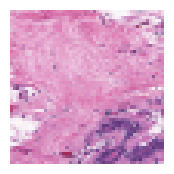

In [7]:
patients_list = os.listdir(path)
image = Image.open(path + "/10253/0/10253_idx5_x1001_y1001_class0.png")
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.axis('off') # Hide axes for cleaner display
plt.show()

In [8]:
torch.tensor(np.asarray(image)).permute(2,0,1).shape

torch.Size([3, 50, 50])

NOTE: Need to permute

Patient ID: 15473 Class: 0
Patient ID: 16165 Class: 1
Patient ID: 9036 Class: 1
Patient ID: 9076 Class: 1
Patient ID: 15512 Class: 0
Patient ID: 9325 Class: 1
Patient ID: 9076 Class: 1
Patient ID: 10306 Class: 0
Patient ID: 14209 Class: 1


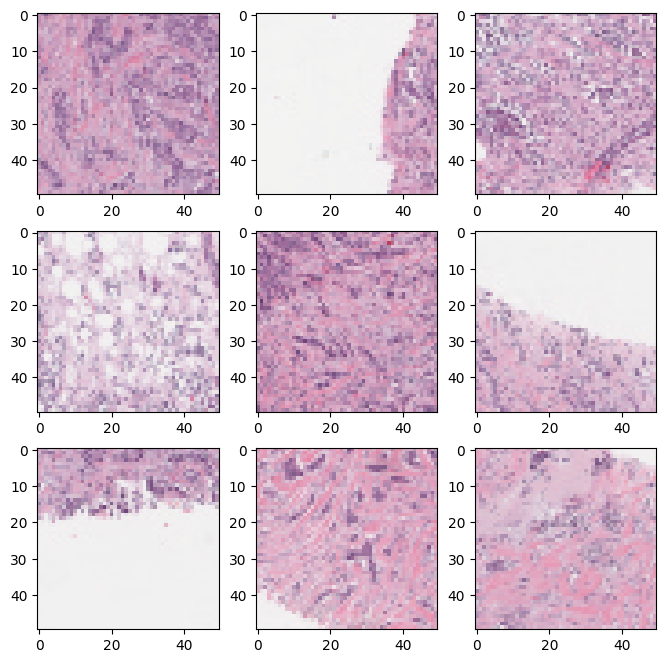

In [9]:
# Playing around with visualization
n_row = n_col = 3
fsize = n_row * 2 + 2
for i in range(n_row * n_col): # Randomly constructing the imgs array
  rand_patient = random.choice(patients_list)
  rand_patient = random.choice(patients_list)
  pos_neg_rand = str(random.randint(0,1))
  print("Patient ID:", rand_patient, "Class:", pos_neg_rand)
  imgs = [np.asarray(Image.open(path + "/"+rand_patient+"/"+pos_neg_rand+"/" + file)) for file in os.listdir(path + "/"+rand_patient+"/"+pos_neg_rand)[:n_row * n_col]]

_, axs = plt.subplots(n_row, n_col, figsize=(fsize,fsize))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

#### Data prep

Option #1: Two tensors, one for each positive/negative instance; similar tensor denoting labels.

Option #2: One big tensor of all images and another of all labels.


In [11]:
# Data organizing & validation algorithm
#
# patients_list = os.listdir(path)
#
##### Count how many of each file is expected (to pre-allocate space in the tensor)
# Just use the numbers provided in the dataset description, above.
pos_instances = 78786
neg_instances = 198738

##### Check image size & format
def check_im_size(img):
    '''Input: PIL image'''

    return True if ( img.size == (50, 50) ) else ( False )

def check_rgb(img):
    '''Input: PIL image'''

    return True if ( img.mode == 'RGB' ) else ( False )

###### Pre-allocate tensors
pos_imgs_tensor = 0 #torch.zeros(pos_instances, 3, 50, 50)
neg_imgs_tensor = 0 #torch.zeros(neg_instances, 3, 50, 50)
######################################
############## Memory bug ############
# Create method for batching on-the-go
######################################

#
# # Probably don't need...
# pos_classes     = torch.ones(pos_instances)
# neg_classes     = torch.zeros(neg_instances)

###### Loop through dirs and begin populating (pre-allocated) tensors
# Think about combining ideas here with the loop, above
i_pos = i_neg = 0 # initializing counters for pos/neg classified ims
i_count = 0
for patient in patients_list:
  if patient == "IDC_regular_ps50_idx5":
    continue
  for pos_neg in ["0","1"]:
    for file in os.listdir(path + "/"+patient+"/"+pos_neg):
      full_path = path + "/"+patient+"/"+pos_neg+"/"+file
      i_count += 1
      #print("File path:", full_path)
      #if check_im_size(Image.open(full_path)) and check_rgb(Image.open(full_path)):
        #raw_im = Image.open(full_path)
        #im_array = np.asarray(raw_im)
        #img_tensor = torch.tensor(im_array)
        #if pos_neg == "0":
        #  neg_imgs_tensor[i_neg,:,:,:] = img_tensor
        #  i_neg += 1
        #else:
        #  pos_imgs_tensor[i_pos,:,:,:] = img_tensor
        #  i_pos += 1
      #else:
        #print("Invalid image:", full_path)

print(i_count)

#
# i_pos = i_neg = 0 # initializing counters for pos/neg classified ims
#
# For each patient:
#     For each instance_type (pos/neg):
#         raw_im = Image.open(path + "/../..")
#         im_array = np.asarray(raw_im)
#         img_tensor = torch.tensor(im_array)
#
#
#         if instance_type = pos:
#             pos_imgs_tensor[i_pos,:,:,:] = img_tens
#             i_pos += 1
#         else:
#             pos_imgs_tensor[i_neg,:,:,:] = img_tens
#             i_neg += 1

########################################
##### ACTUAL CODE FOR COUNTING INSTANCES
########################################
#patients_list = os.listdir(path)

#pos_instances = neg_instances = 0
#for patient in patients_list:
#  if patient == "IDC_regular_ps50_idx5":
#    continue
#  #print("File path:", path + "/"+patient)
#  pos_instances += len(os.listdir(path + "/"+patient+"/1"))
#  neg_instances += len(os.listdir(path + "/"+patient+"/0"))

#print("Number of positive instances:", pos_instances)
#print("Number of negative instances:", neg_instances)
#print("Total instances:", pos_instances + neg_instances)
#########################################

277524
